<a href="https://colab.research.google.com/github/denebola2015/ITNPB6/blob/main/ITNPD6_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ITNPD6 Assignment 1
Student Number: 3538758

In [1]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2 # A widely compatible version
# Or try scikit-learn==1.3.1 if 1.5.2 doesn't work



Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 2.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.


Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import set_config
from IPython.display import display
from scikeras.wrappers import KerasClassifier

Load Dataset

In [6]:

from google.colab import files
uploaded = files.upload()  # pick the dataset



Saving Assign_wallacecommunications.csv to Assign_wallacecommunications.csv


In [7]:
try:
    df_wallace_communications = pd.read_csv('/content/Assign_wallacecommunications.csv')
except FileNotFoundError:
    print("Error: Please upload your CSV file and verify the path.")

# Identify numerical and categorical features
numerical_features = ['age', 'current_balance', 'this_campaign', 'days_since_last_contact_previous_campaign']
categorical_features = ['town', 'country', 'job', 'married', 'education', 'arrears', 'housing',
                        'has_tv_package', 'last_contact', 'conn_tr', 'last_contact_this_campaign_month',
                        'contacted_during_previous_campaign', 'outcome_previous_campaign']

features_list = ['ID', 'town', 'country', 'age', 'job', 'married', 'education', 'arrears', 'current_balance', 'housing', 'has_tv_package', 'last_contact', 'conn_tr', 'last_contact_this_campaign_month', 'last_contact_this_campaign_day', 'this_campaign', 'days_since_last_contact_previous_campaign', 'contacted_during_previous_campaign', 'outcome_previous_campaign' ]
target_column = 'new_contract_this_campaign'

# Correctly define X and y from the DataFrame
# Convert target variable 'y' from strings ('no', 'yes') to numerical (0, 1)
X = df_wallace_communications[features_list]
y = df_wallace_communications[target_column].map({'no': 0, 'yes': 1})


Handling Missing Values, Defining Pipelines

In [8]:
# Use 'mean' on missing values in numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Use 'most_frequent' on missing values in categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # Convert categories into numbers using OneHotEncoder after imputation
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the pipeline steps for SVM
# Added class_weight='balanced' to address class imbalance
pipe_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', SVC(probability=True, random_state=42, class_weight='balanced'))
])

# initialise random forest classifier as a pipeline to include preprocessing
# Changed n_jobs to 1 to avoid over-parallelization with cross_val_score(n_jobs=-1)
rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=1, oob_score=True, bootstrap=True))
])


Train Test Split, Fit baselines/training data, Preprocessor Transformation for Neural Net

In [9]:
# Train-test split 44 mins-1 hr
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Print initial shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


# Process X_train and X_test for Neural Network model
# The preprocessor is a ColumnTransformer and is designed for features (X), not targets (y)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Print shapes of processed features
print(f"\nOriginal features in X: {X.shape[1]}")
print(f"Processed feature shape (one-hot encoded + scaled): {X_train_processed.shape}")
print(f"Training samples after processing: {X_train_processed.shape[0]}, Testing samples after processing: {X_test_processed.shape[0]}")

# Fit pipelines to training data (X_train, y_train).
# Pipelines 'pipe_svm' and 'rf' already contain the 'preprocessor'.
# and handle the transformation of X_train internally.
# while the target y_train is passed directly as is.
pipe_svm.fit(X_train, y_train)
rf.fit(X_train, y_train)

print("\n--- SVM Pipeline ---")
display(pipe_svm)

print("\n--- Random Forest Pipeline ---")
display(rf)



X_train shape: (40529, 19), y_train shape: (40529,)
X_test shape: (10133, 19), y_test shape: (10133,)

Original features in X: 19
Processed feature shape (one-hot encoded + scaled): (40529, 202)
Training samples after processing: 40529, Testing samples after processing: 10133

--- SVM Pipeline ---


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'current_balance',
                                                   'this_campaign',
                                                   'days_since_last_contact_previous_campaign']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['town', 'country', 'job',
                                                   'married', 'education',
                                                   'arrears', 'housing',
                                                   'has_tv_package',
                                                   'last_contact', 'conn_tr',
                                                   'last_contact_this_campaign_month',
                                                   'contacted_during_previous_campaign',
                                                   'outcome_previous_campaign'])])),
                ('clf',
                 SVC(class_weight='balanced', probability=True,
                     random_state=42))])


--- Random Forest Pipeline ---


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'current_balance',
                                                   'this_campaign',
                                                   'days_since_last_contact_previous_campaign']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['town', 'country', 'job',
                                                   'married', 'education',
                                                   'arrears', 'housing',
                                                   'has_tv_package',
                                                   'last_contact', 'conn_tr',
                                                   'last_contact_this_campaign_month',
                                                   'contacted_during_previous_campaign',
                                                   'outcome_previous_campaign'])])),
                ('clf',
                 RandomForestClassifier(n_estimators=200, n_jobs=1,
                                        oob_score=True, random_state=42))])

Model Choice for Assignment is: SVM, Random Forest, Neural Net

Key Considerations for Using Neural Networks on Tabular Data:

**Preprocessing is mandatory**, mixed data types and missing values are not handled natively

**Architecture**
A simple Multi-Layer Perceptrons (MLPs), consisting of Dense (fully connected) layers, that integrates the Keras Neural Network into a scikit-learn compatible wrapper for cross-validation.

Preprocessing Verification for Neural Net

In [10]:
# 1. Checking for NumPy arrays
assert isinstance(X_train_processed, np.ndarray), "X_train_processed is not a NumPy array."
assert isinstance(X_test_processed, np.ndarray), "X_test_processed is not a NumPy array."
print("Type check passed: Data are NumPy arrays.")

# 2. Checking data type within the arrays: Must be numeric (float or int)
# Neural networks require floats (usually float32 or float64)
assert np.issubdtype(X_train_processed.dtype, np.floating), f"X_train_processed dtype is {X_train_processed.dtype}, expected float."
assert np.issubdtype(X_test_processed.dtype, np.floating), f"X_test_processed dtype is {X_test_processed.dtype}, expected float."
print(f"Data type check passed: Data are floating-point numbers ({X_train_processed.dtype}).")

# 3. Checking for missing (NaN) values
assert not np.isnan(X_train_processed).any(), "X_train_processed contains NaN values."
assert not np.isnan(X_test_processed).any(), "X_test_processed contains NaN values."
print("Missing value check passed: No NaNs found.")


# 4. Checking shapes match expectations
num_features_train = X_train_processed.shape[1]
num_features_test = X_test_processed.shape[1]
assert num_features_train == num_features_test, "Train and test feature counts do not match."
assert X_train.shape[0] == X_train_processed.shape[0], "Training sample size changed unexpectedly."
print(f"Shape check passed: {X_train_processed.shape[0]} training samples, {num_features_train} features.")


# 5. Checking compatibility with the Keras model's expected input shape
input_shape_for_keras = (X_train_processed.shape[1],)
print(f"Keras model input shape should be set to: {input_shape_for_keras}")
print("\nVerification complete: Data is ready for the Keras model.")

Type check passed: Data are NumPy arrays.
Data type check passed: Data are floating-point numbers (float64).
Missing value check passed: No NaNs found.
Shape check passed: 40529 training samples, 202 features.
Keras model input shape should be set to: (202,)

Verification complete: Data is ready for the Keras model.


Neural Net Model Definition

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define the model
def build_nn_model(input_shape):
    model = tf.keras.Sequential([
    # Input layer needs the shape of the features array
        tf.keras.layers.InputLayer(shape=input_shape),
        # First hidden layer (dense, relu activation)
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        # Add dropout
        tf.keras.layers.Dropout(0.2),
        # Second hidden layer
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        # Output layer for binary classification (1 neuron, sigmoid activation)
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ])

    # Compile the model inside the build function for KerasClassifier
    # Binary crossentropy is standard for binary classification
    # Adam optimizer is robust, default learning_rate is typically 0.001
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Wrap the Keras model with KerasClassifier for scikit-learn compatibility
# Ensure input_shape_for_keras is defined before this step (from cell 6Q02NHS6uKg)
# We pass input_shape to the build_fn using model__input_shape
nn_clf = KerasClassifier(model=build_nn_model,
                         model__input_shape=input_shape_for_keras,
                         epochs=20,
                         batch_size=32,
                         verbose=0)

# Explicitly set _estimator_type for scikit-learn compatibility
nn_clf._estimator_type = 'classifier'

print("Neural Network model function and KerasClassifier wrapper defined.")

Neural Network model function and KerasClassifier wrapper defined.


Train Neural Net

In [12]:
history = nn_clf.fit(X_train_processed, y_train, validation_split=0.2)

# Evaluate the model on the test set
y_proba_nn = nn_clf.predict_proba(X_test_processed)[:, 1]
y_pred_nn = (y_proba_nn > 0.5).astype(int)

print("\n--- Model Evaluation ---")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_nn):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nn))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_nn))


--- Model Evaluation ---
Test Accuracy: 0.8423

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      8176
           1       0.65      0.40      0.50      1957

    accuracy                           0.84     10133
   macro avg       0.76      0.68      0.70     10133
weighted avg       0.83      0.84      0.83     10133


Confusion Matrix:
[[7744  432]
 [1166  791]]


Probabilities and Performance Report

In [13]:
y_pred_svm = pipe_svm.predict(X_test)  # predict method of svm
y_pred_rf  = rf.predict(X_test)       # predict method of random forest
y_pred_nn  = nn_clf.predict(X_test_processed) # predict method of neural network

# Generate Probabilities: call predict_proba method of decision tree and random forest classifier passing training test data (X_test), returns the 2nd column ([:,1])
y_proba_svm = pipe_svm.predict_proba(X_test)[:,1]
y_proba_rf = rf.predict_proba(X_test)[:,1]
y_proba_nn = nn_clf.predict_proba(X_test_processed)[:,1]

# Define target names based on the mapping for 'new_contract_this_campaign'
target_names = ['no', 'yes'] # Adjusted for binary mapping (0:no/unknown, 1:yes)

def report(name, y_true, y_pred, y_proba):     # report function created, it accepts parameters name of algorithm, target test, target prediction, target probability
    acc = accuracy_score(y_true, y_pred)       # accuracy_score, is a standalone function from the metrics module. It compares predicted values y_pred with the true y_true
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', pos_label=1) # pos_label=1 for the 'yes' class now that y is numerical
    # precision_recall_fscore_support, takes parameters y_test, y_pred, y_proba; average=binary suggests targets (y_test and y_pred) are binary.
    roc = roc_auc_score(y_true, y_proba) # computes Area Under the Receiver Operating Characteristic Curve as roc: Accepts parameters true binary labels y_true and predicted scores or probabilities y_proba
    print(f"=== {name} ===")
    print(f"Accuracy: {acc:.3f} | Precision: {pr:.3f} | Recall: {rc:.3f} | F1: {f1:.3f} | ROC AUC: {roc:.3f}")
    print(classification_report(y_true, y_pred, target_names=target_names))
    return acc, pr, rc, f1, roc

# calls defined 'report' function above, passing algorithm name, target test y_test,y_pred
metrics_svm = report("SVM (baseline)", y_test, y_pred_svm, y_proba_svm)
metrics_rf = report("Random Forest", y_test, y_pred_rf, y_proba_rf)
metrics_nn = report("Neural Network", y_test, y_pred_nn, y_proba_nn)

=== SVM (baseline) ===
Accuracy: 0.804 | Precision: 0.494 | Recall: 0.599 | F1: 0.541 | ROC AUC: 0.790
              precision    recall  f1-score   support

          no       0.90      0.85      0.88      8176
         yes       0.49      0.60      0.54      1957

    accuracy                           0.80     10133
   macro avg       0.70      0.73      0.71     10133
weighted avg       0.82      0.80      0.81     10133

=== Random Forest ===
Accuracy: 0.866 | Precision: 0.778 | Recall: 0.432 | F1: 0.556 | ROC AUC: 0.868
              precision    recall  f1-score   support

          no       0.88      0.97      0.92      8176
         yes       0.78      0.43      0.56      1957

    accuracy                           0.87     10133
   macro avg       0.83      0.70      0.74     10133
weighted avg       0.86      0.87      0.85     10133

=== Neural Network ===
Accuracy: 0.842 | Precision: 0.647 | Recall: 0.404 | F1: 0.497 | ROC AUC: 0.788
              precision    recall  f1-

Confusion Matrix

<Figure size 640x480 with 0 Axes>

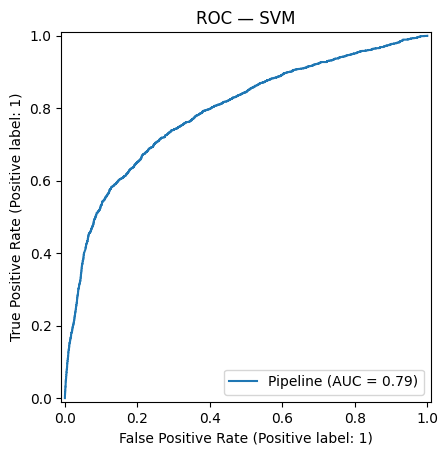

<Figure size 640x480 with 0 Axes>

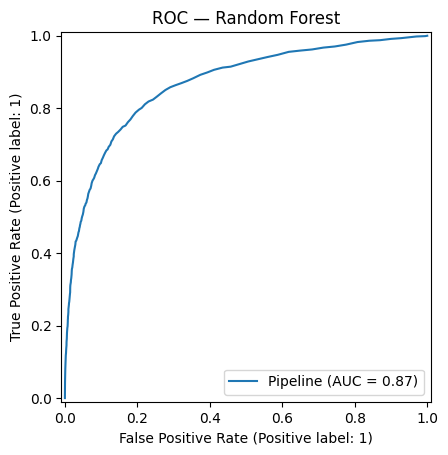

<Figure size 640x480 with 0 Axes>

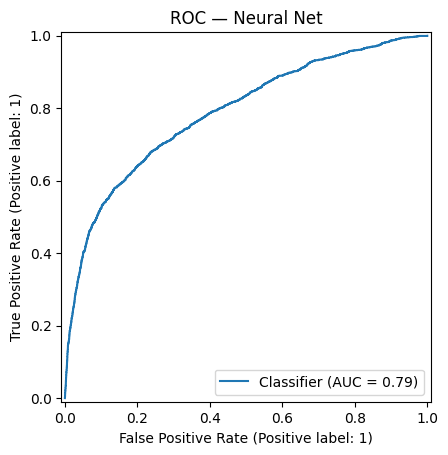

<Figure size 640x480 with 0 Axes>

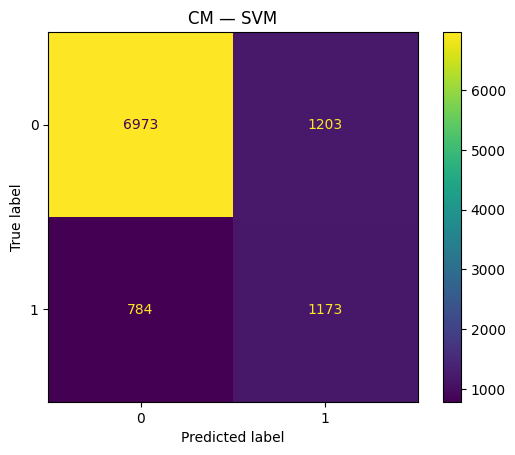

<Figure size 640x480 with 0 Axes>

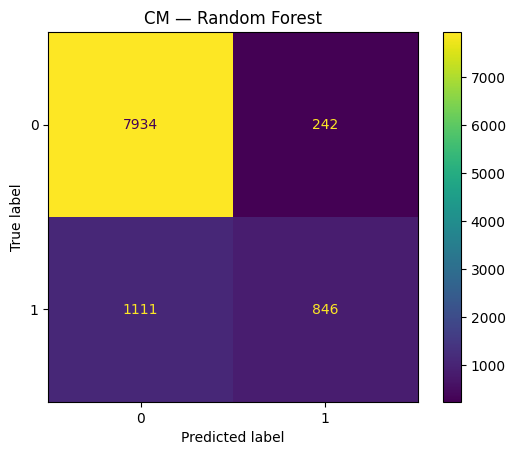

<Figure size 640x480 with 0 Axes>

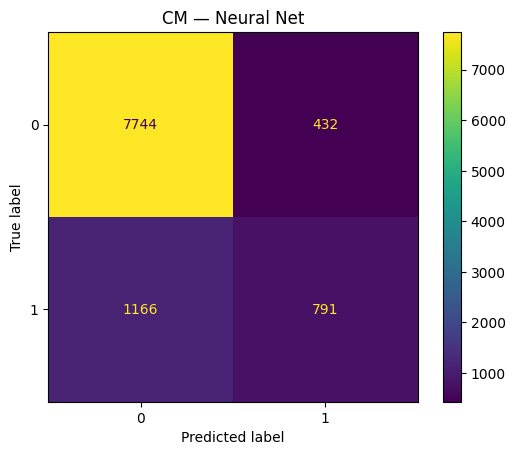

In [14]:
fig = plt.figure(); RocCurveDisplay.from_estimator(pipe_svm, X_test, y_test); plt.title("ROC — SVM"); plt.show()
fig = plt.figure(); RocCurveDisplay.from_estimator(rf, X_test, y_test); plt.title("ROC — Random Forest"); plt.show()
# For KerasClassifier, it's often more robust to use from_predictions with probabilities
fig = plt.figure(); RocCurveDisplay.from_predictions(y_test, y_proba_nn); plt.title("ROC — Neural Net"); plt.show()

fig = plt.figure(); ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm); plt.title("CM — SVM"); plt.show()
fig = plt.figure(); ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf); plt.title("CM — Random Forest"); plt.show()
fig = plt.figure(); ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nn); plt.title("CM — Neural Net"); plt.show()

Manual Stratified CV Scores (Accuracy) for Neural Network


Function 'perform_nn_stratified_cv' defined successfully.


Stratified CV Scores (Accuracy)



In [ ]:
# reduced n_splits to 3 for faster execution. However, this can make performance estimates less stable or representative.
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# StratifiedKFold class from the model_selection library, is a stratified K-Fold cross-validator
# It provides train/test indices to split data in train/test sets. It returns stratified folds
# Parameters: n_splits: int, default=5 Number of folds. Must be at least 2; shuffle:bool, default=False; random_state:int, RandomState instance or None, default=None
# Evaluates a score by cross-validation returns array of scores of the estimator for each run of the cross validation
cv_rf  = cross_val_score(rf,  X, y, cv=cv, scoring="accuracy")
cv_svm = cross_val_score(pipe_svm, X, y, cv=cv, scoring="accuracy")
#cv_nn = cross_val_score(nn_clf, X_train_processed, y_train, cv=cv, scoring="accuracy")
nn_cv_accuracies = perform_nn_stratified_cv(nn_clf, X_train_processed, y_train, cv)

# Evaluate mean scores from CV for RF and CV
print(f"RF CV Accuracy:  mean={cv_rf.mean():.3f} ± {cv_rf.std():.3f}")
(f"SVM CV Accuracy: mean={cv_svm.mean():.3f} ± {cv_svm.std():.3f}")
print(f"NN CV Accuracy (manual): mean={np.mean(nn_cv_accuracies):.3f} \u00b1 {np.std(nn_cv_accuracies):.3f}")
# print(f"NN CV Accuracy: mean={cv_nn.mean():.3f} \u00b1 {cv_nn.std():.3f}")


Create a subset sample of x_train for random search to reduce compute time

In [ ]:
subset_fraction = 0.3

X_train_subset, _, y_train_subset, _ = train_test_split(
    X_train, y_train,
    train_size=subset_fraction,
    stratify=y_train, # Important for maintaining class balance
    random_state=42
)

# Preprocess the subset for the Neural Network RandomizedSearchCV
X_train_subset_processed = preprocessor.transform(X_train_subset)

print(f"Original X_train shape: {X_train.shape}")
print(f"Subset X_train_subset shape: {X_train_subset.shape}")
print(f"Subset X_train_subset_processed shape: {X_train_subset_processed.shape}")
print(f"Original y_train value counts:\n{y_train.value_counts(normalize=True)}")
print(f"Subset y_train_subset value counts:\n{y_train_subset.value_counts(normalize=True)}")

Random Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define svm parameter distributions for a randomized search
param_dist_svm = {
    'clf__kernel': ['linear'],
    'clf__C': uniform(loc=0.1, scale=9.9),  # A continuous distribution between 0.1 and 10.0
    'clf__gamma': ['scale', 'auto', 0.01, 0.1],
    'clf__degree': randint(2, 5) # An integer distribution between 2 (inclusive) and 5 (exclusive) -> [2, 3, 4]
}

# Define rf parameter distributions
param_dist_rf = {
    'clf__n_estimators': randint(50, 200),  # Sample integers between 50 and 200
    'clf__max_depth': [None, 10, 20, 30, 40, 50], # Keep specific important values
    'clf__min_samples_split': randint(2, 11), # Sample integers between 2 and 10
    'clf__min_samples_leaf': randint(1, 5),   # Sample integers between 1 and 4
    'clf__max_features': ['sqrt', 'log2', None]
}

# Define neural network parameter distributions
param_dist_nn = {
    'epochs': randint(10, 50), # Tune epochs from 10 to 49
    'batch_size': [16, 32, 64], # Tune batch size
    'optimizer__learning_rate': uniform(loc=0.0001, scale=0.01) # Tune learning rate for Adam optimizer
}

# Instantiate RandomizedSearchCV for svm
random_search_svm = RandomizedSearchCV(
    estimator=pipe_svm,
    param_distributions=param_dist_svm,
    n_iter=10,  # controls execution time set to 20, 50, 75
    cv=cv,
    verbose=1,
    scoring="roc_auc",
    random_state=42
)

# Instantiate RandomizedSearchCV for rf
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=20,  # Test 20 random combinations
    cv=cv,
    n_jobs=-1,  # Use all available cores for faster processing
    scoring="roc_auc",
    random_state=42 # For reproducibility
)

# Instantiate RandomizedSearchCV for nn
random_search_nn = RandomizedSearchCV(
    estimator=nn_clf,
    param_distributions=param_dist_nn,
    n_iter=10, # Number of parameter settings that are sampled
    cv=cv,
    scoring="roc_auc",
    verbose=1,
    random_state=42
)


# Fit random search objects on the subset of data
random_search_svm.fit(X_train_subset, y_train_subset)
random_search_rf.fit(X_train_subset, y_train_subset)
random_search_nn.fit(X_train_subset_processed, y_train_subset)


print("Best SVM Randomized Search Params:", random_search_svm.best_params_)
print("Best SVM Randomized Search AUC:", random_search_svm.best_score_)

print("\nBest Random Forest Randomized Search Params:", random_search_rf.best_params_)
print("Best Random Forest Randomized Search AUC:", random_search_rf.best_score_)

print("\nBest Neural Network Randomized Search Params:", random_search_nn.best_params_)
print("Best Neural Network Randomized Search AUC:", random_search_nn.best_score_)

Evaluate best models on test set

In [ ]:
best_svm = random_search_svm.best_estimator_
best_rf  = random_search_rf.best_estimator_
best_nn  = random_search_nn.best_estimator_


y_pred_rf_best  = best_rf.predict(X_test)
y_pred_svm_best = best_svm.predict(X_test)
y_pred_nn_best  = best_nn.predict(X_test_processed)

y_proba_rf_best  = best_rf.predict_proba(X_test)[:, 1]
y_proba_svm_best = best_svm.predict_proba(X_test)[:, 1]
y_proba_nn_best  = best_nn.predict_proba(X_test_processed)[:, 1]

print("\n== Tuned Random Forest ==")
_ = report("RF (tuned)", y_test, y_pred_rf_best, y_proba_rf_best)

print("\n== Tuned SVM ==")
_ = report("SVM (tuned)", y_test, y_pred_svm_best, y_proba_svm_best)

print("\n== Tuned Neural Network ==")
_ = report("NN (tuned)", y_test, y_pred_nn_best, y_proba_nn_best)




Performance Tuning

Decision boundaries (pick two features using the drop-down menu)

In [ ]:
feat_x = "ID" # @param ["ID","town","country","age","job","married","education","arrears","current_balance","housing","has_tv_package","last_contact","conn_tr","last_contact_this_campaign_month","last_contact_this_campaign_day","this_campaign","days_since_last_contact_previous_campaign","contacted_during_previous_campaign","outcome_previous_campaign"]
feat_y = "ID" # @param ["ID","town","country","age","job","married","education","arrears","current_balance","housing","has_tv_package","last_contact","conn_tr","last_contact_this_campaign_month","last_contact_this_campaign_day","this_campaign","days_since_last_contact_previous_campaign","contacted_during_previous_campaign","outcome_previous_campaign"]
feat_x = "age"
feat_y = "current_balance"

def plot_2d_boundary(pipe, name):
    Xi = X[[feat_x, feat_y]].values
    Xi_tr, Xi_te, yi_tr, yi_te = train_test_split(Xi, y, test_size=0.25, stratify=y, random_state=42)
    pipe2 = Pipeline([("scaler", StandardScaler()), ("clf", pipe.named_steps["clf"])])
    pipe2.fit(Xi_tr, yi_tr)

    # Grid
    x_min, x_max = Xi[:, 0].min()-0.5, Xi[:, 0].max()+0.5
    y_min, y_max = Xi[:, 1].min()-0.5, Xi[:, 1].max()+0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    Z = pipe2.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.figure(figsize=(6,5))
    plt.contourf(xx, yy, Z, alpha=0.2)
    scatter = plt.scatter(Xi_te[:,0], Xi_te[:,1], c=yi_te, edgecolor="k", alpha=0.9)
    plt.xlabel(feat_x); plt.ylabel(feat_y); plt.title(f"{name} decision regions")
    plt.show()

plot_2d_boundary(best_rf,  "RF (tuned)")
plot_2d_boundary(best_svm, "SVM (tuned)")
